# Aligning the seeds and computing traditional shape descriptors

Once we have managed to segment individual grains, the next step is to get them ready to extract both traditional and topological shape descriptors. To that end, we must place all the seeds in the same frame of reference. For the topological case, we're planning later on using the Eulter Characteristic Transform as proposed by [Turner et al (2014)](https://doi.org/10.1093/imaiai/iau011). This approach depends on filtering our seeds according to a fixed set of directions, so all seeds must be pointing at the same direction for comparison of filters to make sense.

In this particular case, the grains are oblong in shape and we're able to align them based on their principal components using SVD. Once a seed is aligned, it's easy to measure:
- length
- height
- width
- volume
- surface area
- volume of the convex hull
- surface area of the convex hull
- ratio of convex hull area vs grain surface area
- ratio of convex hull volume vs grain volume

<img src=https://www.egr.msu.edu/~amezqui3/barley/figs/seed_orientation3.png width="600">

In [1]:
import tifffile as tf
import scipy.ndimage as ndimage
from scipy.spatial import ConvexHull
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
import pandas as pd

# All the image preprocessing functions are found in `barley_brew`

- The `barley_brew` module is simply a repository of _ad hoc_ image processing functions to clean X-ray CT scans
- The module is not meant to be directly used outside the barley project, but rather provide some inspiration of what can be done to address basic X-ray CT cleaning woes.
- Hence, this notebook attempts to flesh out the functions in the module so other readers might be inspired to try similar tricks on their own.

In [7]:
import demeter.misc as misc
import demeter.traditional as traditional

## Load a seed image

In [3]:
seed_file = '../example_data/seed_8_0_p7_d4_t120_o7_e1_g3.tif'
img = tf.imread(seed_file)

img = ndimage.binary_fill_holes(img).astype(img.dtype)
img = ndimage.binary_closing(img).astype(img.dtype)
img = ndimage.binary_fill_holes(img).astype(img.dtype)

## Get the coordinates of the voxels

- To compute the principal components, we must consider the pixels/voxels as 2D or 3D coordinate points.
- For example, if we would have the binary image on the left below

<img src=https://www.egr.msu.edu/~amezqui3/barley/figs/cubical_complex.png width="400">

- We expect to have a matrix of coordinates that goes like

```
[[0,0], [0,3], [0,4], [1,1], [1,2], [1,3], ...  ]
```
- Coordinate values will be centered as well.

In [4]:
def tiff2coords(img, center=True):
    coords = np.nonzero(img)
    coords = np.vstack(coords).T
    if center:
        origin = -1*np.mean(coords, axis=0)
        coords = np.add(coords, origin)

    return coords

In [5]:
coords = tiff2coords(img, center=True)
coords

array([[-37.02711062,   7.24746129, -12.67696436],
       [-37.02711062,   7.24746129, -11.67696436],
       [-37.02711062,   7.24746129, -10.67696436],
       ...,
       [ 35.97288938,  -6.75253871,  14.32303564],
       [ 35.97288938,  -6.75253871,  15.32303564],
       [ 35.97288938,  -6.75253871,  16.32303564]])

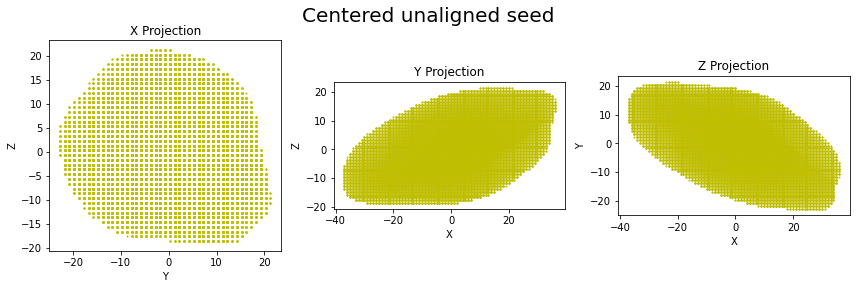

In [8]:
misc.plot_3Dprojections(coords, 'Centered unaligned seed')

## Align based on principal components using SVD

- We use singular value decomposition (SVD) to compute the principal components to use as frame of reference (x,y,z)-axes
    - **X axis**: Proximal-distal 
    - **Y-axis**: Medial-lateral 
    - **Z-axis**: Adaxial-abaxial

- We need to make sure that the proximal, medial, and adaxial sides of the grain are all on the positive side of their respective axes.
- To that end, we keep track of the proximal tip with `find_tip`
- We also keep track of the trough (abaxial side)
- `rotateSVD` returns 
    - `seed`: the aligned coordinates
    - `sigma`: the principal component values
    - `vh` : The rotation matrix
    - `rotZ`: bool to indicate if values were rotated 180 degrees on the Z axis
    - `rotX`: bool to indicate if values were rotated 180 degrees on the X axis

In [10]:
max_vox = misc.find_tip(coords, 2,1,0)
seed, sigma, vh, rotZ, rotX = misc.rotateSVD(coords, max_vox)
seed

array([[-39.16334409,   5.910622  ,  -3.94145514],
       [-38.88729968,   5.17913368,  -4.56493274],
       [-38.61125526,   4.44764535,  -5.18841033],
       ...,
       [ 38.50062434,  -7.40682351,   2.76329342],
       [ 38.77666875,  -8.13831184,   2.13981582],
       [ 39.05271316,  -8.86980016,   1.51633823]])

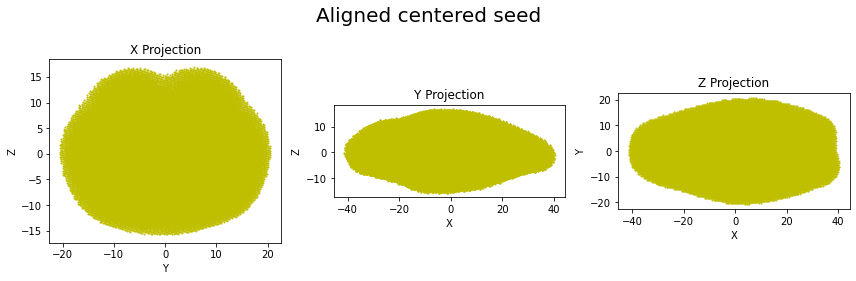

In [11]:
misc.plot_3Dprojections(seed, 'Aligned centered seed')

## Traditional descriptors

- By simply looking at the aligned coordinates, we get length, width, and height of each grain.
    - `heightmax` refers to the distance between the lowest point to the highest point in the X-projection (transverse plane)
    - `height` refers to the distance between the bottom point to the top point at the center, ideally, the low spot of the trough.
    

- For the 3D case, we look at the 6-neighborhood (up, down, left, right, back, forth) of each voxel to determine the outermost voxels.
    - `area_cube`: looks at the number of _voxel cubes_ in the outermost layer
    - `area_sq`: looks at the number of _voxel's faces_ in the outermost layer

In [12]:
def seed_lengths(seed, x=0,y=1,z=2):
    maxs, mins = np.max(seed, axis=0), np.min(seed, axis=0)
    length, width, heightmax = maxs - mins
    height = np.max(seed[ np.abs(seed[:,y]) < 0.5 ], axis=0)[z] - mins[z]
    
    return length, width, height, heightmax

In [13]:
def seed_area_vol(img, coords, border):
    img[img > 0] = 1
    surface = ndimage.convolve(img, border, np.int8, 'constant', cval=0)
    
    surface[ surface < 0 ] = 0
    area_sq = np.sum(surface)
    area_cube = np.sum(surface > 0)
    vol = np.sum(img)
    
    hull = ConvexHull(coords)
    
    area_ratio = area_sq/hull.area
    vol_ratio = vol/hull.volume
    
    return area_sq,area_cube,vol,hull.area,hull.volume,area_ratio,vol_ratio

In [15]:
csv_file = '/home/ejam/documents/barley_stacks/corrected_metadata.csv'
scan_path = '/home/ejam/documents/barley_stacks/preproc/comps/S224/'
dst = '/home/ejam/documents/barley_stacks/preproc/seeds/'
dst = '/home/ejam/downloads/temp/'
color_list = ['Blue', 'Orange', 'Red', 'Green']
save_coords = True

border = np.array([[[0,0,0],[0,-1,0],[0,0,0]],
                  [[0,-1,0],[-1,6,-1],[0,-1,0]],
                  [[0,0,0],[0,-1,0],[0,0,0]]])

In [32]:
importlib.reload(traditional)
summary = traditional.traditional_summary(dst, csv_file, scan_path, color_list, border, save_coords)

***********************************
S224 Blue
Seeds not found in  /home/ejam/documents/barley_stacks/preproc/comps/S224/
***********************************
S224 Orange
Seeds not found in  /home/ejam/documents/barley_stacks/preproc/comps/S224/
***********************************
S224 Red
***********************************
S224 Green
Seeds not found in  /home/ejam/documents/barley_stacks/preproc/comps/S224/


In [33]:
summary

,Scan,Color,Generation,Selection,Progeny,Label (C-G-S-P),Founder,Label,Length,Width,Height,HeightMax,Shell,Area,Vol,ConvexArea,ConvexVol,ConvexAreaRatio,ConvexVolRatio,Tag
877,S224,Red,7,211,2,R-7-211-2,NaN,0,104.354593,45.865573,38.351948,44.733585,9810,17966,91977,11720.804499,95396.666667,1.532830,0.964153,seed_8_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,97.010764,46.412697,33.537636,37.291361,8909,15828,80835,10525.336502,82392.833333,1.503800,0.981093,seed_19_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,78.248915,39.423388,28.665776,31.365706,5849,11092,47556,7217.929843,47910.166667,1.536729,0.992608,seed_21_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,100.771818,48.423346,35.539199,41.616702,9450,17124,85982,11114.051092,89045.000000,1.540752,0.965602,seed_12_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,102.927680,45.894574,35.301508,39.729810,9403,17588,86631,11238.315039,89757.166667,1.565003,0.965171,seed_15_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,99.444780,47.363693,40.746400,40.804708,9211,16614,86065,11049.211411,88190.666667,1.503637,0.975897,seed_16_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,102.242453,47.245020,35.457960,39.476679,9395,17594,87884,11285.852475,91091.000000,1.558943,0.964793,seed_9_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,93.547640,47.217082,39.054258,39.134885,8371,15266,77079,10115.987279,78466.166667,1.509096,0.982321,seed_20_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,102.955076,45.424076,34.737203,38.480408,9384,17012,85539,11137.658052,88154.333333,1.527431,0.970332,seed_11_0
877,S224,Red,7,211,2,R-7-211-2,NaN,0,100.148804,47.837364,34.723262,40.202001,9352,17424,86125,11171.393790,89409.666667,1.559698,0.963263,seed_17_0
